In [21]:
# 📦 Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Chargement des fichiers CSV (chemins nettoyés)
df_facture = pd.read_csv("C:/Users/User/Downloads/factures_fact.csv", sep=',')
df_admission = pd.read_csv("C:/Users/User/Downloads/admission_fact.csv", sep=',')
df_patient = pd.read_csv("C:/Users/User/Downloads/dim_patient.csv", sep=',')
df_cout = pd.read_csv("C:/Users/User/Downloads/dim_cout.csv", sep=',')

# 👀 Affichage des premières lignes
print("🧾 FACTURE")
display(df_facture.head())

print("\n🏥 ADMISSION")
display(df_admission.head())

print("\n🧑‍⚕️ PATIENT")
display(df_patient.head())

print("\n💸 TYPE DE COUT")
display(df_cout.head())


🧾 FACTURE


,patient_id,length_of_stay,facility_cost,procedure_cost,medication_cost,lab_test_cost,total_cost,subject_id,hadm_id
0,10006,8,8000,10500,21600,196300,236400,10006,142345
1,10011,13,13000,3000,0,70000,86000,10011,105331
2,10013,2,2000,1500,3600,14800,21900,10013,165520
3,10017,8,8000,3000,42000,47700,100700,10017,199207
4,10019,0,0,6000,0,28700,34700,10019,177759



🏥 ADMISSION


,subject_id,hadm_id,hospital_expire_flag,admission_count,procedure_count,los,Time_key
0,10006,142345,0,NaN,NaN,39.18,5032094
1,10006,142345,0,NaN,NaN,172.89,5032094
2,10006,142345,0,NaN,NaN,NaN,5032094
3,10011,105331,1,NaN,NaN,332.42,5062090
4,10011,105331,1,NaN,NaN,NaN,5062090



🧑‍⚕️ PATIENT


,subject_id,dob,gender,insurance,language,religion,marital_status,ethnicity
0,10006,2094-03-05 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
1,10011,2090-06-05 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
2,10013,2038-09-03 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
3,10017,2075-09-21 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
4,10019,2114-06-20 00:00:00,M,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE



💸 TYPE DE COUT


,drug,drug_type,dose_val_rx,dose_unit_rx,amount,cost_id
0,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,400.0,1
1,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,NaN,3
2,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,200.0,5
3,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,30.0,7
4,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,NaN,9


In [22]:
#  Fusionner les tables factures et patients par 'subject_id' (clé de fusion)
df = pd.merge(df_facture, df_patient, on='subject_id', how='left')
df.columns

Index(['patient_id', 'length_of_stay', 'facility_cost', 'procedure_cost',
       'medication_cost', 'lab_test_cost', 'total_cost', 'subject_id',
       'hadm_id', 'dob', 'gender', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity'],
      dtype='object')

In [23]:
# Décaler toutes les dates de naissance de 120 ans en arrière
df['dob'] = pd.to_datetime(df['dob'])  # Assurer que c'est bien datetime
df['dob'] = df['dob'] - pd.DateOffset(years=120)

# Maintenant recalculer l'âge
current_year = datetime.now().year
df['age'] = df['dob'].apply(lambda x: current_year - x.year)
print(df['age'])


0      51
1      55
2     107
3      70
4      31
     ... 
85     41
86     88
87     67
88     38
89     33
Name: age, Length: 90, dtype: int64


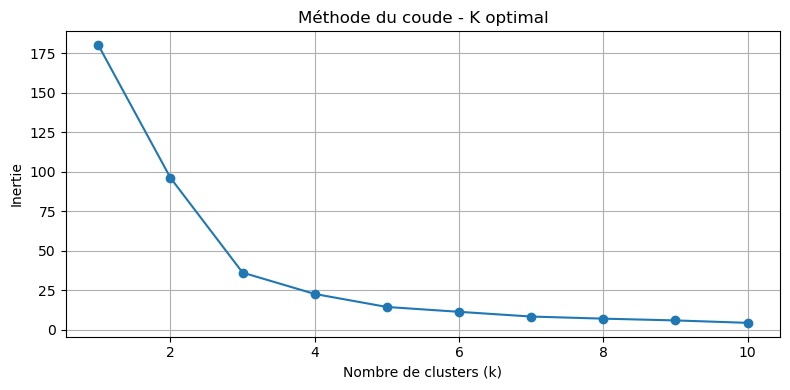

✅ Silhouette score (KMeans) : 0.55


In [24]:
features = ['total_cost', 'age']
# ⚙️ Configuration pour éviter les warnings liés à MKL sous Windows
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Important : à mettre AVANT les imports sklearn

# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df[features]

# ⚖️ Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔍 Recherche du nombre optimal de clusters (méthode du coude)
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # ← ici n_init est bien fixé
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 📊 Affichage de la courbe du coude
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Méthode du coude - K optimal')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Application de K-Means avec k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# 📈 Score de silhouette
score = silhouette_score(X_scaled, df['cluster_kmeans'])
print(f"✅ Silhouette score (KMeans) : {score:.2f}")

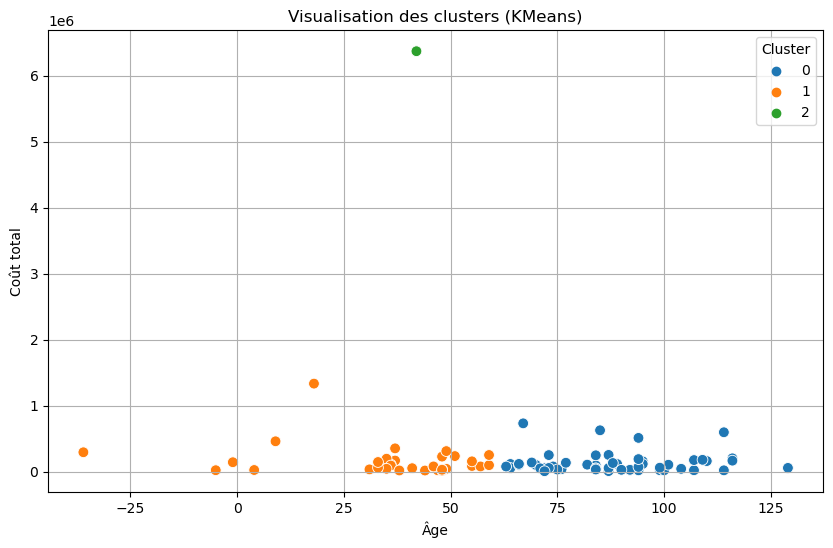

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='total_cost', hue='cluster_kmeans', palette='tab10', s=60)
plt.title('Visualisation des clusters (KMeans)')
plt.xlabel('Âge')
plt.ylabel('Coût total')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


In [25]:
import pickle

# Sauvegarde du scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Sauvegarde du modèle kmeans
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
#########################fin#################

In [13]:
import pickle

# Charger le scaler
with open('C:/Users/User/OneDrive/Bureau/flaskPI/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Charger le modèle KMeans
with open('C:/Users/User/OneDrive/Bureau/flaskPI/kmeans_model.pkl', 'rb') as f:
    kmeans = pickle.load(f)


In [15]:
# Charger tous tes fichiers
df_facture = pd.read_csv("C:/Users/User/Downloads/factures_fact.csv", sep=',')
df_patient = pd.read_csv("C:/Users/User/Downloads/dim_patient.csv", sep=',')

# Fusionner les factures et les patients sur 'subject_id'
df = pd.merge(df_facture, df_patient, on='subject_id', how='left')


In [16]:
from datetime import datetime
import pandas as pd

# Corriger la date de naissance
df['dob'] = pd.to_datetime(df['dob'])
df['dob'] = df['dob'] - pd.DateOffset(years=120)  # Retirer 120 ans si besoin
current_year = datetime.now().year
df['age'] = df['dob'].apply(lambda x: current_year - x.year)


In [17]:
# Maintenant ton df contient bien 'total_cost' et 'age'
X = df[['total_cost', 'age']]


In [18]:
X_scaled = scaler.transform(X)
df['cluster_kmeans'] = kmeans.predict(X_scaled)


In [19]:
cluster_info = df.groupby('cluster_kmeans')['total_cost'].mean().sort_values()
print(cluster_info)


cluster_kmeans
0    1.292667e+05
1    1.554586e+05
2    6.368150e+06
Name: total_cost, dtype: float64


In [20]:
# Mapping automatique
mapping = {
    0: "coût faible",
    1: "coût moyen",
    2: "coût élevé"
}
